# Mini-Project 02 Let's implement a Neural Network using NumPy

**DNN (Deep neural network)** is mainly used as a classification algorithm. In this project, I will give you the basic concept of the neural network and ask you to implement the **basic** algorithm in NumPy from Scratch.

This project is to give you a basic sense on how the Neural Network (NN) works. Our main mission to learn how to use NumPy to implement an NN but not the performance of the system. To ease your life, we will start with a basic classifier that classifies only letters.

## 0) Loading image



The letter is W


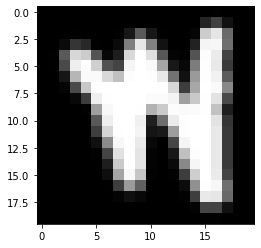

In [1]:
#data.py
# Used to load images
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os 
# load the images

def load_images():
    images = os.listdir('./data')
    X = []
    Y = np.load('label.npy')
    #load the images
    for i in range(1000):
        #The image is in shape(28,28,3) width=28, height=28, channel(RGB) = 3
        #R=G=B since the figure is gray
        image = cv2.imread('./data/%d.png'%(i+1)).astype('uint8')
        
        #Scale down(up) the figure so that it fit out model(input size: 20*20*1)
        image = cv2.resize(image,(20,20),interpolation=cv2.INTER_AREA)
        X.append(image)
    X = np.array(X)
    return X,Y
    

if __name__ == '__main__':
    #plot the first figure as a sample
    letters = [chr(x+ord('A')) for x in range(26)]
    X,Y = load_images()
    print('The letter is %s'%letters[Y[0]])
    plt.imshow(X[0])
    plt.show()

## 0.1) Loading image: from image to data

We now have a set of figures $X$,and corresponding label $Y$.

### The format of $X$

- Image in $X$ is a numpy array with shape [28,28,3], the value is an integer and in range [0,255].
- Our mission model is to predict gray scale handwritten letter. 
- To fit in the model, the image is transformed into an image of shape [50,50,1] with floating value in range [0,1].
- We define the convertion as the following:
> $value = ((R+G+B)//3)/255)$


### The format of $Y$

- Labels in $Y$ is an integer in range [0,25] (i.e., 26 alphabets) represent the alphabet order.
- In most classification framework, the labels are stored in an one-hot vector.

- For instance, the letter **c** is the 3rd letter so it's label index is 2 (the index start from 0)
    - The one-hot representation of letter **c** is 
    >[0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    - which is a binary vector with all 0 except index of the label
     



In [2]:
#data.py

def one_hot(label):
    one_hot_label = [0]*26
    one_hot_label[label] = 1
    return one_hot_label    

def load_data():
    X,Y = load_images()
    X = (X.sum(axis=3)//3)/255
    X = X.reshape(X.shape[0],-1) # convert each image into a col vecotr [50*50,1]
    Y = np.array(list(map(one_hot,Y)))
    return X,Y

## 1) Neural Network: single neuron (many-to-one)

The most basic component of a neural network is a neuron.

Our **first task** is to use a neuron to implement binary classification to classify whether the label of an image is letter **C** or not. We apply the following **many (inputs) to one (output)** neural network to complete this task.

![Nerual Network](https://c.mql5.com/2/35/artificialneuron__1.gif)

## 1.1) Single Label Classification Task

### Input

- The image array, e.g., $\vec{x}=X[0]$, a column vector of 20*20 values.

### Output

- The output is **ONE float value** in range [0,1]
- If the output >=0.5: Yes, it is an image of **c**
- If the output <0.5: No, it is not an image of **c**


### Data
- We select the first 100 figures in X as dataset.
- We split the dataset in ratio 8:2, first 80 as training, and last 20 as validation
- Since the task is only to output 0 or 1, so the label here is a binary value
- the amount of letter 'C' is 2 in training and 1 in validation



In [3]:
#Section1_neuron.py

from data import load_data, one_hot
import numpy as np
import math

def data_processing():
    def one_hot_to_binary(one_hot_label):
        binary_label = map(lambda x:1 if x[2]==1 else 0,one_hot_label)
        return np.array(list(binary_label)) 
        
    X,Y = load_data()
    
    train_X,train_Y = X[:80],Y[:80]
    val_X,val_Y = X[80:100],Y[80:100]
    
    train_Y = one_hot_to_binary(train_Y)
    val_Y = one_hot_to_binary(val_Y)
    
    amount_of_c_in_train = train_Y.sum()
    amount_of_c_in_val =val_Y.sum()
    print('amount_of_c_in_train=%d'%amount_of_c_in_train)
    print('amount_of_c_in_val=%d'%amount_of_c_in_val)
    return train_X,train_Y,val_X,val_Y

## 1.2) Forwarding of Neuron 
### What does a neuron do?
- A neuron is a linear model, the output of the neuron is a linear combination of parameter (weight) and input (x)
- Typically, a neuron applies **a weighted sum function** and **an activation function** to generate the **output**.




### Weighted sum function

- Let's assume that $\vec{x}=X[0]$ (the first image)
    - $\vec{x}$ is a column vector of shape (400,1)
- The weight vector $\vec{w}$ of the (output) neuron should have 400 weight values since there are 400 input features (values).
    - $\vec{w}$ is also a column vecotr of shape (400,1)
    - $\vec{w}^\top$ transforms $\vec{w}$ into a row vector $[w_1,...,w_{400}]$
- The weighted sum function can be defined as
> $\vec{w}^\top\cdot \vec{x} = \sum_i x_iw_i = x_1w_1+x_2w_2+...+x_{400}w_{400}$

### Activation function (output value, $y$)

- By appling a non-linear activation function to the output of the neuron, it can empower the fitting ability of the model.
> $y=f(sum(\vec{w}^\top \cdot \vec{x})) = sigmoid(sum(\vec{w}^\top \cdot \vec{x})) = \frac{1}{1+e^{-sum(\vec{w}^\top \cdot \vec{x})}}$
- Sigmoid function is a widely used activate function, it map the output to range (0,1) and the derivative is easy to calculate.
    - $sigmoid(x) = \sigma(x) = \frac{1}{1+e^{-x}}$
    - The derivative: $\sigma(x)' = \sigma(x)*(1-\sigma(x))$

In [6]:
# utils.py
# define the sigmoid activator and it's gradient (derivative) for backpropagation

class SigmoidActivator():
    def forward(self, weighted_input):
        return 1.0 / (1.0 + np.exp(-weighted_input))
    def backward(self, output):
        return output * (1 - output)

# [CHALLENGE] How can we design the weight vector in a Neuron?

- The intuition is to **fine-tune** (train) the weight vector $\vec{w}$ so that the output successfully predicts **the label of the input image**.
- For instance, forward$(\vec{x}, \vec{w})$ should return $y$ approximate to $1$ if $\vec{x}$ is an image of letter **C**.

## 1.2) Backpropagation

https://www.youtube.com/watch?v=iyn2zdALii8&ab_channel=StatQuestwithJoshStarmer

### How do we train the network?

- **Backpropagation** is a popular method for training artificial neural networks, especially deep neural networks.

### Error function
- We use $MSE$ (mean square error) as the error function, we claim the output of the neuron is $y$, and the target is $\bar y$
- $MSE(y,\bar y) = (y-\bar y)^2$

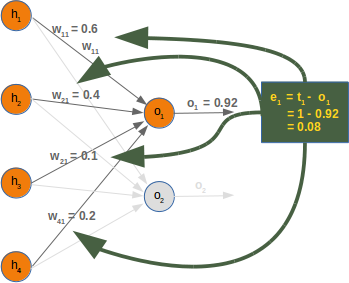

(This figure just shows you the basic concept but we don't use the notations in this figure)

## 1.3) Gradients Descent (for the Output Layer)
https://vincentblog.xyz/posts/backpropagation-and-gradient-descent

The weight can be updated **iteratively** by a gradient descent apporach. 

> $\delta = \sigma(y)' * (\bar{y}-y)$

> $\delta = y(1-y)(\bar{y}-y)$

where $\delta$ is the gradient error term derived by Calculus based on the **error** between the **predicted value** $y$ and the **ground truth value** $\bar{y}$

> $\begin{align}
  \vec{w}_{new}&=\vec{w}_{old}+\eta \cdot \delta \vec{x}\\
               &=\vec{w}_{old}+\eta \cdot y(1-y)(\bar{y}-y)\cdot \vec{x}
  \end{align}$

> $\begin{bmatrix}
w_1 \\
w_2 \\
... \\
w_m \\
\end{bmatrix}_{new}=
\begin{bmatrix}
w_1 \\
w_2 \\
... \\
w_m \\
\end{bmatrix}_{old}+\eta \cdot y(1-y)(\bar{y}-y)
\begin{bmatrix}
x_1 \\
x_2 \\
... \\
x_m \\
\end{bmatrix}$

where $\delta \vec{x}$ is the **adjustment** and $\eta$ is the learning rate (e.g., 0.05).

Note that the gradient is derived from the derivative (**calculus**) of the function, detail can be found in many [articles](https://towardsdatascience.com/gradient-descent-from-scratch-e8b75fa986cc).



Notation

$\vec x$ = input \
$y$ = output \
$\bar{y}$ = label \
$\delta$ = delta \
$\sigma$ = sigmoid function \
$\eta$ = learning rate


In [2]:
#Section1_neuron.py
class Neuron():
    def __init__(self, input_num, activator):
        self.activator = activator
        self.weights = np.array([0.0] * input_num)

    def __str__(self):
        np.set_printoptions(threshold=np.inf)
        return 'w = np.{0}'.format(repr(self.weights))


    def forward(self, x):
        '''
        the forwarding part
        '''
        weighted_sum = np.dot(self.weights.T,x)
        return self.activator.forward(weighted_sum)

    def update_weights(self, x, y, label, learning_rate):
        delta = self.activator.backward(y) * (label - y)
        self.weights = self.weights + learning_rate*delta*x
        
    def train(self, X, labels, epochs=100, learning_rate=0.01):

        for i in range(epochs):
            
            accuracy = self.one_iteration(X, labels, learning_rate)
            if (i%5 ==0):
                print('epoch %d:'%i,end='')
                print('accuracy in training is %.2f %%'%accuracy)
                
    def one_iteration(self, X, labels, rate):
        success_case = 0
        for i in range(len(X)):
            x = X[i]
            label = labels[i]
            y = self.forward(x)
            
            self.update_weights(x, y, label, rate)
        accuracy = success_case/len(X)*100
        return accuracy


In [3]:
#Section1_neuron.py

#main function for training and validation
if __name__ == '__main__':
    train_X,train_Y,val_X,val_Y = data_processing()
    neuron = Neuron(train_X.shape[1],SigmoidActivator())
    
    #training
    neuron.train(train_X,train_Y,100,0.01)
    
    #validation
    success_case = 0
    for i in range(len(val_X)):
        #calssify the image is c if the output >=0.5
        if val_Y[i] == (1 if neuron.forward(val_X[i])>=0.5 else 0):
            success_case += 1
    accuracy = success_case/len(val_X)*100
    print('accuarcy in validation dataset is %.2f %%'%accuracy)
    

NameError: name 'data_processing' is not defined

## 2) 1-Layer Neural Network: multiple neurons (many-to-many)

In the previous example and mathematic equations, we assume that there is only one neuron (**binary classification**) for the output (many-to-one). In this section, we are going to introuce you how to do **multi-label classification** using multiple neurons.

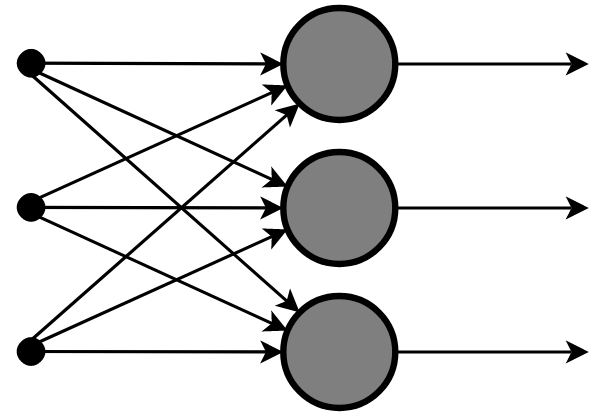

## 2.1) Output vector $\vec{y}$

In our example, there are 26 output neurons so the output $y$ should be transformed into a vector $\vec{y}$. 

Originally,
> $\bar y = [1]$ for the image of label **c**\
> $\bar y = [0]$ for the image of other labels

Now,
> $\vec{\bar y}^\top = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]$ for the image of label **c**\
> $\vec{\bar y}^\top = [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]$ for the image of label **l**\
> $\vec{\bar y}^\top = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]$ for the image of label **s**



## 2.2) Weight vectors $\vec{w_i}$ and weight matrix $\mathrm{W}$

Previously, our weight vector $\vec{w}$ is defined as 
> $\vec{w}^\top=[w_1,...,w_{400}]$

In our example, we should have 26 output neurons in total. Thereby, the corresponding weight vectors are revised as
> $\vec{w_1}^\top=[w_{1,1},...,w_{1,400}]$\
> $\vec{w_2}^\top=[w_{2,1},...,w_{2,400}]$\
> $\vec{w_3}^\top=[w_{3,1},...,w_{3,400}]$\
> $\cdots$\
> $\vec{w_{26}}^\top=[w_{26,1},...,w_{26,400}]$

> $dim(\vec{w_1}^\top) = dim(\vec{w}^\top) = (1,400)$



Mathematically, (for ease of handling), we can combine these 26 vectors into a weight matrix $\mathrm{W}$ as follows.
> $\mathrm{W}=\begin{bmatrix}
\vec w_1^\top \\
\vec w_2^\top \\
... \\
\vec w_{26}^\top \\
\end{bmatrix}$


> $dim(\mathrm{W})=(26,400)$

## 2.3) Feedforward of weight matrix $\mathrm{W}$

### Weighted sum function

Originally,
> $y = \vec w^\top \cdot \vec x$

Now, 
- Given $\vec{x}$ (dim=(1,400)) and the weight matrix $\mathrm{W}$ (dim=(3,400))
- The weighted sum function can be defined as

> $ W\cdot \vec x = 
\begin{bmatrix}
\vec{w_1}^\top\vec{x} \\
\vec{w_2}^\top\vec{x} \\
... \\
\vec{w_{26}}^\top\vec{x} \\
\end{bmatrix}$



### Activation function (output vector, $\vec{y}$)

> $\vec{y}=sigmoid(W\cdot \vec x) = \frac{1}{1+e^{-(W\cdot \vec x)}}$

## 2.4) Gradient descent of the layer of 26 neurons (output layer)

Similarly, the weight matrix can be updated **iteratively** by the gradient descent apporach. 

Originally,
> $\delta = y(1-y)(\bar{y}-y)$

> $\vec{w}_{new}=\vec{w}_{old}+\eta \cdot \delta \vec{x}=\vec{w}_{old}+\eta \cdot y(1-y)(\bar{y}-y)\vec{x}$

Now,
> $\vec{\delta}=\vec{y}([1]_{26}-\vec{y})(\vec{\bar{y}}-\vec{y})$

- $dim(\vec{\delta})=dim(\vec{y})=(26,1)$.

> $\mathrm{W}_{new} \gets \mathrm{W}_{old} + \eta \cdot \vec{\delta}\vec{x}^\top \quad \quad (Eq.1)$

- $dim(\vec{\delta})=(26,1)$ and $dim(\vec{x})=(400,1)$. 
- Thus, $dim(\vec{\delta}\vec{x}^\top)=(26,400)$ which has the same dim to $\mathrm{W}$.



Notation

$\vec x$ = input \
$\vec y$ = output \
$\delta$ = delta \
$\eta$ = learning rate 





In [1]:
#layer.py

import numpy as np
class FullConnectedLayer():
    def __init__(self, input_size, output_size, 
                 activator):
        self.input_size = input_size
        self.output_size = output_size
        self.activator = activator
        self.W = np.random.uniform(-0.1, 0.1,
            (output_size, input_size))
        
        self.y = np.zeros((output_size, 1))
        
        
    def forward(self, x):
        self.x = x
        self.y = self.activator.forward(
            np.dot(self.W, x))
        
    def backward(self, delta_array):
        '''
        Your task 1
        - calculate the Gradient in Eq.1
        - (refer to the 2nd term in Eq.1)
        '''
        
        # ****** Your code begin (task 1) ******
        # self.W_grad = the dot product of vector delta_array and the transpose of vector x
        
        
        # ****** Your code end (task 1) ******
        
        # Don't touch other code
        self.delta = self.activator.backward(self.x) * np.dot(
            self.W.T, delta_array)
        
    def update(self, learning_rate):
        # Eq.1 in Sec. 2.4
        self.W = self.W + learning_rate * self.W_grad

In [12]:
#Section2_1layerNN.py
import numpy as np
#from layer import FullConnectedLayer
from utils import SigmoidActivator
from data import load_data

class Network():
    def __init__(self, input_size,output_size):
        self.layer =FullConnectedLayer(
                        input_size, output_size,
                        SigmoidActivator()
                    )
    def __str__(self):
        np.set_printoptions(threshold=np.inf)
        return 'W = np.{0}'.format(repr(self.layer.W))

    def forward(self, x):
        self.layer.forward(x)
        y = self.layer.y
        return y
    
    def train(self, X, Y, epoch=100,learning_rate=0.01):
        for i in range(epoch):
            success_case = 0
            for d in range(len(X)):
                y = self.train_one_sample(X[d], 
                    Y[d], learning_rate)
                if np.argmax(y) == np.argmax(Y[d]):
                    success_case+=1
            accuracy = success_case/len(X)*100
            if (i%5 ==0):
                print('epoch %d:'%i,end='')
                print('accuracy in training is %.2f %%'%accuracy)
    def train_one_sample(self, x, y, learning_rate):
        output = self.forward(x)
        self.calc_gradient(y)
        self.update_weight(learning_rate)
        return output
    def calc_gradient(self, label):
        delta = self.layer.activator.backward(
            self.layer.y
        ) * (label - self.layer.y)
        self.layer.backward(delta)
    def update_weight(self, learning_rate):
        self.layer.update(learning_rate)


In [14]:
#Section2_1layerNN.py

def data_processing():
        
    X,Y = load_data()
    train_X,train_Y = X[:800],Y[:800]
    val_X,val_Y = X[800:1000],Y[800:1000]
    train_X = train_X.reshape((*train_X.shape,1))
    train_Y = train_Y.reshape((*train_Y.shape,1))
    val_X = val_X.reshape((*val_X.shape,1))
    val_Y = val_Y.reshape((*val_Y.shape,1))
    #amount_of_c_in_train = train_Y.sum()
    #amount_of_c_in_val =val_Y.sum()
    #print('amount_of_c_in_train=%d'%amount_of_c_in_train)
    #print('amount_of_c_in_val=%d'%amount_of_c_in_val)
    return train_X,train_Y,val_X,val_Y

if __name__ == '__main__':
    train_X,train_Y,val_X,val_Y = data_processing()
    model = Network(train_X.shape[1],train_Y.shape[1])
    
    #training
    epochs = 1000
    learning_rate = 0.01
    model.train(train_X,train_Y,epochs,learning_rate)
    
    #validation
    success_case = 0
    for i in range(len(val_X)):
        #calssify the image is c if the output >=0.5
        if np.argmax(val_Y[i]) == np.argmax(model.forward(val_X[i])):
            success_case += 1
    accuracy = success_case/len(val_X)*100
    print('accuarcy in validation dataset is %.2f %%'%accuracy)
    

AttributeError: 'FullConnectedLayer' object has no attribute 'W_grad'

## 3) 2-layer Neural Network

<div>
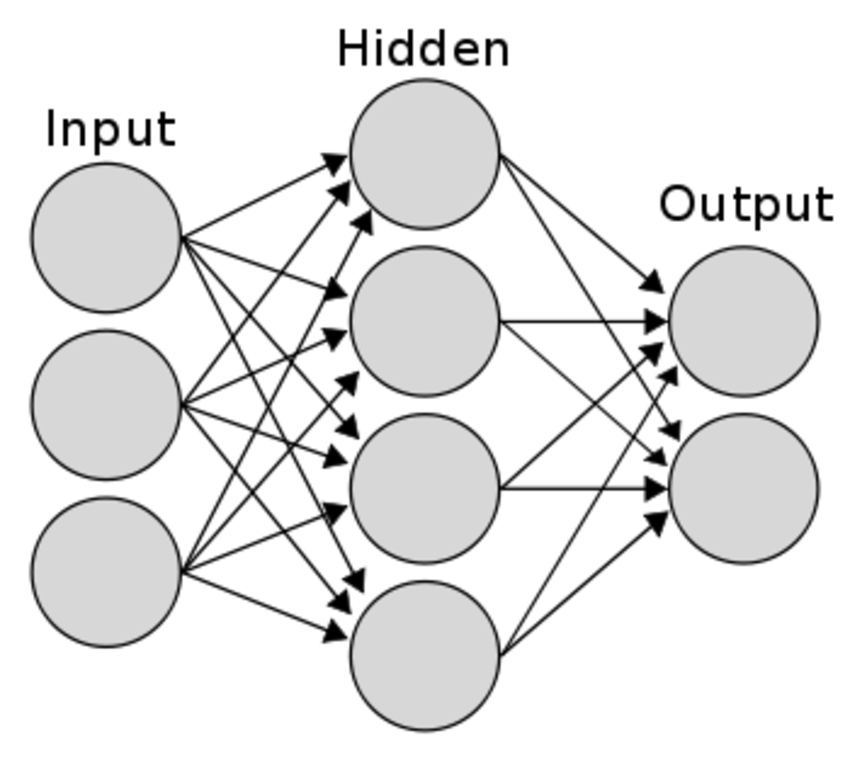
</div>

## 3.1) Feedforward - Hidden Neuron (refer to 2.3)

Now we have two layers so we have two weight matrix $\mathrm{W}^{(1)}$ (Input-Hidden) and $\mathrm{W}^{(2)}$ (Hidden-Output) for two layers, respectively.

We set dimension of $\mathrm{W}^{(1)}$ as (100,400)
and dimension of $\mathrm{W}^{(2)}$ as (26,100)

layer 1 is a hidden layer which get the input from $\vec{x}$(400,1) and hidden output $\vec{a}$(100,1)\
layer 2 is the output layer which get the input from $\vec{a}$(100,1) and output $\vec{y}$(26,1)

### Weighted sum function

>$ W^{(1)}\cdot \vec x = 
\begin{bmatrix}
\vec{w_1^{(1)}}^\top\vec{x} \\
\vec{w_2^{(1)}}^\top\vec{x} \\
... \\
\vec{w_{26}^{(1)}}^\top\vec{x} \\
\end{bmatrix}$



### Activation function (hidden vector, $\vec{a}$)

> $\vec{a}=sigmoid(W^{(1)}\cdot \vec x) = \frac{1}{1+e^{-sum(W\cdot \vec x)}}$

## 3.2) Feedforward - Output Neuron

### Weighted sum function

>$ W^{(2)}\cdot \vec a = 
\begin{bmatrix}
\vec{w_1^{(2)}}^\top\vec{a} \\
\vec{w_2^{(2)}}^\top\vec{a} \\
... \\
\vec{w_{100}^{(2)}}^\top\vec{a} \\
\end{bmatrix}$


### Activation function (output vector, $\vec{y}$)

> $\vec{y}=sigmoid(W^{(2)}\cdot \vec a) $

## 3.3) Gradient descent of the Output Layer (refer to 2.4)

> $\vec{\delta^{(2)}}=\vec{y}([1]_{26}-\vec{y})(\vec{\bar{y}}-\vec{y}) \quad \quad (Eq.2)$

- $dim(\vec{\delta^{(2)}})=(26,1)$

> $\mathrm{W^{(2)}}_{new} \gets \mathrm{W^{(2)}}_{old} + \eta \cdot \vec{\delta^{(2)}}\cdot \vec{a}^\top$

## 3.4) Gradient descent of the hidden Layer

> $\vec{\delta^{(1)}}=\vec{a}([1]_{100}-\vec{a})\mathrm{W^{(2)}}^T\vec{\delta^{(2)}} \quad \quad (Eq.3)$


- $dim(\mathrm{W^{(2)}})=(26,100)$
- $dim(\vec{\delta^{(2)}})=(26,1)$
- $dim(\vec{\delta^{(1)}})=(100,1)$

> $\mathrm{W^{(1)}}_{new} \gets \mathrm{W^{(1)}}_{old} + \eta \cdot \vec{\delta^{(l)}}^T\vec{x} \quad \quad$


Notation

$\vec{a}$ = hidden layer output \
$y$ = output layer output \
$\bar{y}$ = label \
$\delta$ = delta \
$\eta$ = learning rate


In [ ]:
#3_2layerNN.py

#reuse the layer define in section 2

import numpy as np
#from layer import FullConnectedLayer
from utils import SigmoidActivator
from data import load_data

class Network():
    def __init__(self, input_size,hidden_size,output_size):
        self.layers = []
        self.layers.append(FullConnectedLayer(
                        input_size, hidden_size,
                        SigmoidActivator()
                        )
                    )
        self.layers.append(FullConnectedLayer(
                        hidden_size, output_size,
                        SigmoidActivator()
                        )
                    )
    def __str__(self):
        np.set_printoptions(threshold=np.inf)
        result = ''
        for i in range(len(self.layers)):
            result +='W{1} = np.{0}'.format(repr(self.layers[i].W),i+1) +'\n\n'
        return result
    def train(self, X, Y, epoch=100,learning_rate=0.01):
        for i in range(epoch):
            success_case = 0
            for d in range(len(X)):
                y = self.train_one_sample(X[d], 
                    Y[d], learning_rate)
                if np.argmax(y) == np.argmax(Y[d]):
                    success_case+=1
            accuracy = success_case/len(X)*100
            if (i%5 ==0):
                print('epoch %d:'%i,end='')
                print('accuracy in training is %.2f %%'%accuracy)
    def train_one_sample(self, x, y, learning_rate):
        output = self.forward(x)
        self.calc_gradient(y)
        self.update_weight(learning_rate)
        return output
    def forward(self, x):
        self.layers[0].forward(x)
        a = self.layers[0].y
        self.layers[1].forward(a)
        y = self.layers[1].y
        return y
    def calc_gradient(self, label):
        '''
        Your task 3
        - a) calculate the gradient of output layer
          (refer to the in Eq.2 of Section 3.3)
        
        - b) calculate the gradient of hidden layer
          (refer to the in Eq.3 of Section 3.4)
        '''
        
        # ****** Your code begin (task 3a) ******
        # out_delta = Reference Section2_1layerNN.py
        
        # ****** Your code end (task 3a) ******
        
        self.layers[1].backward(out_delta)
        
        
        # ****** Your code begin (task 3b) ******
        # hid_delta = Reference Eq.3 and backward function in layer.py , the hid_delta is got from output layer
        # ****** Your code end (task 3b) ******
        
        self.layers[0].backward(hid_delta)
        return self.layers[0].delta
    
    def update_weight(self, learning_rate):
        for layer in self.layers:
            layer.update(learning_rate)
        

In [17]:
#3_2layerNN.py
def data_processing():
        
    X,Y = load_data()
    train_X,train_Y = X[:800],Y[:800]
    val_X,val_Y = X[800:1000],Y[800:1000]
    train_X = train_X.reshape((*train_X.shape,1))
    train_Y = train_Y.reshape((*train_Y.shape,1))
    val_X = val_X.reshape((*val_X.shape,1))
    val_Y = val_Y.reshape((*val_Y.shape,1))
    #amount_of_c_in_train = train_Y.sum()
    #amount_of_c_in_val =val_Y.sum()
    #print('amount_of_c_in_train=%d'%amount_of_c_in_train)
    #print('amount_of_c_in_val=%d'%amount_of_c_in_val)
    return train_X,train_Y,val_X,val_Y

if __name__ == '__main__':
    train_X,train_Y,val_X,val_Y = data_processing()
    hidden_size = 100
    model = Network(train_X.shape[1],hidden_size,train_Y.shape[1])
    
    #training
    epochs = 1000
    learning_rate = 0.01
    model.train(train_X,train_Y,epochs,learning_rate)
    
    #validation
    success_case = 0
    for i in range(len(val_X)):
        #calssify the image is c if the output >=0.5
        if np.argmax(val_Y[i]) == np.argmax(model.forward(val_X[i])):
            success_case += 1
    accuracy = success_case/len(val_X)*100
    print('accuarcy in validation dataset is %.2f %%'%accuracy)
    

NameError: name 'out_delta' is not defined

## 4) In this mini-project, your tasks include

1. Complete the update function in layer.py according to 2.4.
    - Try to make the 2_1layerNN.py be runnable to train a one-layer model.
3. Complete the calc_gradient function in 3_2layerNN.py according to 3.3 and 3.4
    - Try to make the 3_2layerNN.py be runnable to train a two-layer model.
3. Follow the instructions on slides to submit your model to CDS Online Judge

In [1]:
#train.py

import numpy as np
from data import load_data

#from Section3_2layerNN import Network,data_processing


train_X,train_Y,val_X,val_Y = data_processing()

# The judge system limit the length of code, so hidden_size should less than 100 if you do not set a small print precision
hidden_size = 100
model = Network(train_X.shape[1],hidden_size,train_Y.shape[1])


#training
epochs = 1000
learning_rate = 0.01
model.train(train_X,train_Y,epochs,learning_rate)

np.set_printoptions(precision=8)
#save weights
with open('save_weights.txt','w') as f:
    f.write(str(model))

NameError: name 'data_processing' is not defined

## 5) Submission

- You can submit your own model, make sure the script contains all the parts of your model. 
    - (backward and train can be omitted)
- Below is a template to submit a well-trained 2-layer NN with one hidden layer.

In [4]:
import numpy as np

class SigmoidActivator():
    def forward(self, weighted_input):
        return 1.0 / (1.0 + np.exp(-weighted_input))
    def backward(self, output):
        return output * (1 - output)
    
    
class FullConnectedLayer():
    def __init__(self, input_size, output_size, 
                 activator):
        self.input_size = input_size
        self.output_size = output_size
        self.activator = activator
        self.W = np.random.uniform(-0.1, 0.1,
            (output_size, input_size))
        self.y = np.zeros((output_size, 1))
    def forward(self, x):
        self.x = x
        self.y = self.activator.forward(
            np.dot(self.W, x))
        
class Network():
    def __init__(self, input_size,hidden_size,output_size):
        self.layers = []
        self.layers.append(FullConnectedLayer(
                        input_size, hidden_size,
                        SigmoidActivator()
                        )
                    )
        self.layers.append(FullConnectedLayer(
                        hidden_size, output_size,
                        SigmoidActivator()
                        )
                    )
    def forward(self, x):
        self.layers[0].forward(x)
        a = self.layers[0].y
        self.layers[1].forward(a)
        y = self.layers[1].y
        return y
        
def predict(x):
    '''
    Don't forget to set the hid_size
    '''
    hid_size = 1
    model = Network(20*20,hid_size,26)
    model.layers[0].W = W1
    model.layers[1].W = W2
    
    return model.forward(x)

#copy and paste the trained weight from 'save_weights.txt' as below

W1 = np.array([[ 6.85212970e-02,  1.26087640e-02,  9.35512534e-03,
         7.63099791e-02, -6.92518712e-02, -5.58669789e-02,
        -5.74259593e-02, -7.79696347e-02,  3.95189177e-02,
         8.59661530e-02, -6.88694252e-02, -9.55430161e-02,
         9.35278607e-02,  7.26770454e-02,  5.46625799e-02,
        -3.27280761e-02, -2.88224024e-02,  6.11950746e-02,
        -5.53029655e-03,  9.19718981e-02, -7.87170068e-02,
         3.40080279e-02, -8.33326294e-02, -4.10881156e-02,
         1.51830756e-02, -7.15193039e-02,  8.09573810e-02,
         1.21470772e-02, -2.42070185e-02, -5.78557164e-02,
        -2.83948848e-02,  8.45405265e-02, -4.88543732e-02,
         2.44576595e-02, -1.99258865e-02, -4.53320091e-02,
         5.56844992e-02, -3.94045819e-02, -2.46548340e-02,
         1.67231875e-02,  5.68989175e-02, -2.38764690e-02,
         9.04540995e-02,  1.14146275e-01, -1.18806393e-02,
         6.78121919e-03,  5.36513065e-02,  1.65947301e-01,
         1.53954210e-01,  8.09886735e-04,  1.19465387e-01,
        -1.10908988e-02, -1.73678493e-02, -5.95181920e-02,
         5.49682388e-02, -3.36529505e-02,  2.04934750e-02,
        -8.96812223e-02,  1.31709318e-02,  1.55382284e-04,
         1.88911435e-02,  1.08605052e-01, -2.65970473e-02,
         1.97350665e-02,  1.90263576e-01,  1.27996825e-01,
         4.85795810e-02,  1.95154084e-01,  5.70518131e-02,
         2.04799188e-01,  2.07513688e-01,  1.06065697e-01,
         1.63845267e-01, -8.27158172e-03,  8.26394472e-04,
         1.06619721e-01,  9.97756528e-02, -3.56325622e-02,
        -1.82325022e-02, -6.04061762e-02,  8.50827319e-02,
         4.67225160e-02, -2.14073948e-02,  9.90713593e-02,
         4.34330550e-02,  1.90240496e-01,  2.04703230e-01,
         1.98866455e-01,  1.87247251e-01,  1.00443135e-01,
         1.81346662e-01,  1.92383290e-01,  2.02055753e-02,
         1.41724359e-01,  1.61571590e-01,  4.25163383e-02,
         6.19380673e-03, -4.62367752e-02, -7.49054329e-02,
         2.47910130e-02,  4.56024193e-03,  7.32913675e-02,
        -3.72919112e-02,  3.14388461e-04,  6.55546875e-02,
         1.52637166e-01,  5.61475473e-02,  2.14023831e-01,
         1.07065835e-01,  1.24858198e-01,  1.88905185e-01,
         5.45566329e-02,  2.15329273e-01,  9.15871843e-02,
         9.34738638e-02,  7.70897083e-02,  6.53898259e-02,
         3.30391114e-02,  4.71425432e-03, -7.67204686e-03,
        -8.76771097e-02,  4.58668205e-02,  2.27881563e-02,
        -5.47552194e-03,  1.89884448e-01,  1.66395794e-01,
         8.21310246e-02,  1.35755524e-01,  2.50140788e-01,
         1.63575357e-01,  2.47147852e-01,  9.72878620e-02,
         8.30792711e-02,  2.26083634e-01,  1.50801942e-01,
         1.27673042e-01,  1.17343428e-01,  9.92687792e-02,
         8.89735213e-02,  8.33246899e-02, -4.86882673e-02,
         3.90838725e-02,  5.00105319e-02,  7.20196029e-02,
         1.52238268e-01,  7.81721196e-02,  1.17893702e-01,
         1.70056945e-01,  2.54964702e-01,  2.07176670e-01,
         1.12501828e-01,  9.71797635e-02,  1.08698404e-01,
         5.49401851e-02,  1.07531947e-01,  1.34600353e-01,
         1.68003311e-01, -5.74798715e-02, -7.21898651e-02,
         1.41047121e-02,  6.23347496e-02,  2.99732308e-02,
         1.41464467e-01,  1.29331260e-01,  1.28373781e-01,
         2.89530033e-02,  1.37541903e-01,  1.09909066e-01,
         2.80968216e-01,  2.17996645e-01,  2.34371475e-01,
         1.64575121e-01,  1.57545570e-01,  1.59660371e-01,
         1.63162151e-01,  6.10552921e-02,  7.96895609e-02,
         2.88723114e-02,  4.25692886e-02,  6.31905947e-02,
         2.85919273e-02,  5.46648912e-02,  5.69624593e-02,
         8.97125133e-02,  9.35200287e-02,  1.89430304e-01,
         8.39321165e-02,  7.63188558e-02,  2.68290640e-01,
         1.49371061e-01,  2.76363496e-01,  1.40498886e-01,
         2.60288523e-01,  1.29894364e-01,  1.55359117e-01,
         2.12182540e-01,  3.09347833e-02,  1.04857768e-02,
         9.63650083e-02, -1.85740649e-02,  2.49090838e-02,
         1.03528334e-01, -5.78772815e-02,  4.93395243e-02,
         2.80975546e-02,  6.95686601e-02,  1.05737941e-01,
         9.61765860e-02,  1.34419190e-01,  2.88456879e-01,
         2.16039311e-01,  2.51811590e-01,  1.65848743e-01,
         1.34121545e-01,  2.10960114e-01,  3.31354631e-02,
         1.69249552e-01,  7.36546062e-02, -2.94388083e-02,
        -8.46816145e-03,  7.22231972e-03, -6.86339640e-02,
         1.38141165e-01,  1.44760982e-01,  1.37380409e-01,
         2.96089940e-02,  9.24768588e-02,  7.67061029e-02,
         1.55710073e-01,  2.36173714e-01,  2.49704381e-01,
         1.79643921e-01,  2.04797524e-01,  7.36588031e-02,
         3.84636203e-02,  1.23677591e-01,  8.12863059e-02,
        -1.81747230e-02,  1.12726850e-01,  3.53159653e-02,
        -8.80037854e-02, -1.17013199e-02,  4.55340971e-02,
         1.74095200e-02,  9.25404379e-02,  1.37689557e-01,
         6.95057283e-02,  5.31934791e-02,  1.07259319e-01,
         2.74145940e-01,  1.44913924e-01,  1.30898375e-01,
         6.48482568e-02,  2.23368535e-01,  2.04659927e-01,
         1.08407728e-01,  2.09397299e-01,  1.09031995e-01,
         7.85119895e-02,  1.89777725e-02, -6.80854639e-02,
        -1.75398153e-02,  4.25262523e-02, -1.10926979e-02,
         4.86970551e-02,  6.78840553e-02,  5.76798660e-02,
         1.43598306e-01,  2.02550267e-01,  1.59086059e-01,
         2.32556776e-01,  1.72676204e-01,  1.82668515e-01,
         5.47691381e-02,  1.30077158e-01,  5.60600035e-02,
         1.02951520e-01,  5.50138559e-02,  1.13324874e-01,
        -1.21200874e-02,  8.64236884e-02, -3.41200264e-02,
         1.61625654e-02,  6.81995242e-02,  8.80310165e-02,
         1.22005238e-01,  1.99192092e-01,  1.88285687e-01,
         1.03721097e-01,  6.04935742e-02,  8.77198887e-02,
         1.80339747e-01,  2.65565903e-01,  1.82273612e-01,
         9.25935593e-02,  2.31456454e-01,  1.67122148e-01,
         1.09201683e-01,  8.63792536e-02, -1.64765131e-02,
         5.62601482e-02,  3.64538925e-02,  1.12138962e-01,
         9.81898227e-02,  1.22236195e-01,  6.41005842e-02,
         1.36379572e-01,  1.87803016e-01,  1.84393360e-01,
         1.74242482e-01,  2.47249593e-01,  1.12295841e-01,
         9.97149151e-02,  1.94306665e-01,  1.33289351e-01,
         1.27758192e-01,  6.63995993e-02, -2.17996597e-02,
         5.65436791e-02, -4.58603973e-02,  3.51762642e-02,
        -3.34584384e-02,  7.57173190e-02,  5.54746740e-02,
         1.37347654e-01,  6.99781507e-02,  5.83082344e-02,
         1.34711010e-01,  1.42917384e-01,  1.11625181e-01,
         1.01632245e-01,  2.52965708e-01,  1.41490876e-01,
         1.95484587e-01,  1.23513931e-01, -9.48861434e-03,
         1.18207526e-02,  1.22815058e-01,  1.93829609e-02,
         7.25670206e-02,  5.46941540e-02,  6.24330107e-02,
         5.73599877e-02, -6.40730610e-02, -7.67756535e-02,
        -3.72055495e-03,  5.94494216e-02,  4.18239119e-02,
         1.62718310e-01,  1.30803029e-01,  3.03866790e-02,
         1.39696702e-01,  1.60141570e-01,  3.27824366e-02,
         1.35422870e-01,  4.92840625e-02,  7.22591532e-02,
        -4.88649317e-02,  6.28346982e-02,  8.44260247e-02,
        -6.78991007e-02,  7.69026345e-02,  3.57164403e-02,
        -7.27051486e-02, -5.81697873e-02,  2.14222182e-03,
         7.82710969e-02, -5.80279005e-02,  6.05127374e-02,
         5.56865116e-02,  3.64853086e-02, -2.19189296e-02,
         5.41505234e-02,  8.95687511e-02,  8.01743527e-02,
        -7.57562236e-02,  1.23262545e-02,  5.03759716e-02,
         1.04359778e-02,  7.75465855e-02, -6.68277489e-02,
         6.88830463e-02, -5.29161279e-02, -1.23340159e-03,
         1.84288424e-02, -8.38924707e-02,  7.63506458e-02,
        -9.51871541e-02,  4.47818071e-02,  2.36254531e-02,
        -3.47639020e-02, -6.31068032e-02, -1.57663103e-02,
         6.15615449e-02,  8.14996244e-02, -7.99572846e-02,
        -6.38813036e-02,  9.99535045e-02,  8.17061924e-02,
         5.50161509e-02]])

W2 = np.array([[-2.84687036],
       [-2.7944754 ],
       [-2.75436656],
       [-2.86096346],
       [-2.89009683],
       [-2.83498064],
       [-2.79452922],
       [-2.83185558],
       [-2.88868543],
       [-2.88895139],
       [-2.84781085],
       [-2.69975298],
       [-2.83465508],
       [-2.84757632],
       [-2.87417418],
       [-2.91443138],
       [-2.84892479],
       [-2.91521532],
       [-2.90235455],
       [-2.82096025],
       [-2.63283537],
       [-2.91340299],
       [-2.74143346],
       [-2.92945343],
       [-2.82034789],
       [-2.84712241]])



x = np.array([pixel for pixel in input().split()]).astype(np.float32)
x.reshape((*x.shape,1))

print(np.argmax(predict(x)))


2


ValueError: shapes (1,400) and (1,) not aligned: 400 (dim 1) != 1 (dim 0)